<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,8)
import SimpleITK as sitk
import sys, os
import numpy as np
import pandas as pd
import xarray as xr
import pickle as pkl
from mre.preprocessing import MREDataset
from mre.mask import add_elast_mask
from mre.registration import MRELiverMask
from mre.registration import add_liver_mask 
from mre.plotting import display_images_with_alpha
from ipywidgets import interact, fixed
from IPython.display import clear_output
%load_ext autoreload
%autoreload 2

Some Notes:
Using the T1Dual atlas with the T2SS fixed seems like it produces very good results.  The ring of fat helps anchor the images together and leads to a better liver ID

Aggregate the moving image data, sort it, and put it into a single itk object.

In [3]:
ls /pghbio/dbmi/batmanlab/Data/CombinedHealthyAbdominalOrganSegmentation/MR_data_batch1/

1/  10/  13/  15/  19/  2/  20/  3/  5/  8/  notes.txt*  test.txt


In [4]:
ls /pghbio/dbmi/batmanlab/bpollack/predictElasticity/data/MRE/

148/  220/  296/  354/  370/  388/  405/                   mre_ds_transform_2.p
162/  222/  299/  357/  371/  391/  406/                   mre_part2.zip
163/  239/  302/  358/  372/  394/  data_preprocess_v1.nc
178/  264/  331/  360/  375/  396/  mre_ds_1.p
189/  280/  332/  361/  380/  399/  mre_ds_preprocess_1.p
195/  289/  343/  363/  381/  402/  mre_ds_preprocess_2.p
197/  292/  350/  365/  383/  403/  mre_ds_preprocess_3.p
218/  295/  351/  368/  386/  404/  mre_ds_transform_1.p


In [5]:
mask_maker = MRELiverMask('222', '19', verbose=True, center=True, fixed_seq='T1Pre', moving_seq='T1_inphase')

Fixed Image info for /pghbio/dbmi/batmanlab/bpollack/predictElasticity/data/MRE//222/T1Pre.nii:
Image size: 256 256 4
Image dims: 1.5 1.5 11.5
Image orig: -194.75900268554688 -186.08099365234375 31.406600952148438
Fixed Image info for /pghbio/dbmi/batmanlab/Data/CombinedHealthyAbdominalOrganSegmentation/MR_data_batch1//19/T1_inphase.nii:
Image size: 288 288 30
Image dims: 1.4409722089767456 1.4409722089767456 9.0
Image orig: -202.23243713378906 -211.3795928955078 -135.0


In [6]:
plt.figure()
interact(display_images_with_alpha, image_z=(0, mask_maker.moving_img.GetSize()[2]-1),
         alpha=(0.0,1.0,0.05), fixed = fixed(mask_maker.moving_img),
         moving=fixed(mask_maker.moving_mask))
plt.figure()

<Figure size 720x576 with 0 Axes>

interactive(children=(IntSlider(value=14, description='image_z', max=29), FloatSlider(value=0.5, description='alpha', max=1.0, step=0.05), Output()), _dom_classes=('widget-interact',))

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

Text(0.5,1,'Moving Image w/ Liver Mask')

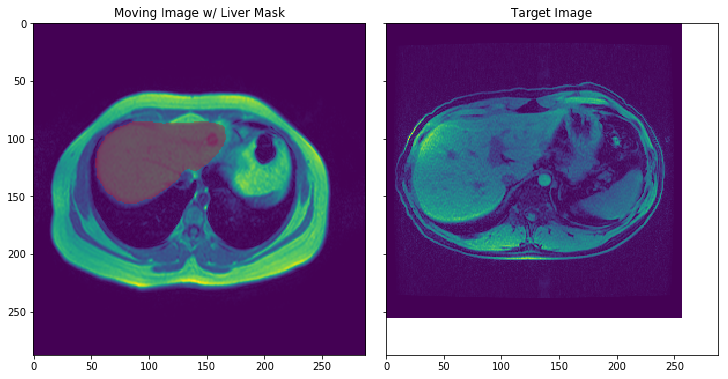

In [16]:
fig, axs = plt.subplots(1, 2, constrained_layout=True, sharex=True, sharey=True)
axs = axs.flatten()
axs[1].imshow(sitk.GetArrayFromImage(mask_maker.fixed_img)[0])
axs[1].set_title('Target Image')
axs[0].imshow(sitk.GetArrayFromImage(mask_maker.moving_img)[22])
mask = sitk.GetArrayFromImage(mask_maker.moving_mask)[22]
mask = np.ma.masked_where(mask == 0, mask)
axs[0].imshow(mask, alpha=0.3, cmap='autumn')
axs[0].set_title('Moving Image w/ Liver Mask')

Now let's interpolate everything so we're dealing with the same dimensions.

# Registration

Going to copy and paste in some methods from simpleITK notebook, attempt basic registration.

In [10]:
mask_maker.gen_param_map()

In [11]:
mask_maker.register_imgs()

In [12]:
mask_maker.gen_mask(smooth=True)

In [13]:
#interact(display_images_with_alpha, image_z=(0, fixed_image.GetSize()[2]-1), alpha=(0.0,1.0,0.05), fixed = fixed(fixed_image), moving=fixed(seg_image));
plt.figure()
interact(display_images_with_alpha, image_z=(0, mask_maker.moving_img.GetSize()[2]-1),
         alpha=(0.0,1.0,0.05), fixed = fixed(mask_maker.moving_img),
         moving=fixed(mask_maker.moving_mask))
plt.figure()
interact(display_images_with_alpha, image_z=(0, mask_maker.fixed_img.GetSize()[2]-1),
         alpha=(0.0,1.0,0.05), fixed = fixed(mask_maker.fixed_img),
         moving=fixed(mask_maker.moving_mask_result))
plt.figure()
interact(display_images_with_alpha, image_z=(0, mask_maker.fixed_img.GetSize()[2]-1),
         alpha=(0.0,1.0,0.05), fixed = fixed(mask_maker.fixed_img),
         moving=fixed(mask_maker.moving_img_result))


<Figure size 720x576 with 0 Axes>

interactive(children=(IntSlider(value=14, description='image_z', max=29), FloatSlider(value=0.5, description='alpha', max=1.0, step=0.05), Output()), _dom_classes=('widget-interact',))

<Figure size 720x576 with 0 Axes>

interactive(children=(IntSlider(value=1, description='image_z', max=3), FloatSlider(value=0.5, description='alpha', max=1.0, step=0.05), Output()), _dom_classes=('widget-interact',))

<Figure size 720x576 with 0 Axes>

interactive(children=(IntSlider(value=1, description='image_z', max=3), FloatSlider(value=0.5, description='alpha', max=1.0, step=0.05), Output()), _dom_classes=('widget-interact',))

<function mre.plotting.display_images_with_alpha>

In [177]:
tmp_mask_res = sitk.GetArrayFromImage(mask_maker.moving_mask_result)
tmp_mask = sitk.GetArrayFromImage(mask_maker.moving_mask)

In [3]:
full_data_dir = '/pghbio/dbmi/batmanlab/Data/MRE/'
ds = pkl.load(open(full_data_dir+'mre_ds_preprocess_2.p', 'rb'))

In [4]:
ds = add_liver_mask(ds)

100%|██████████| 48/48 [3:57:11<00:00, 292.54s/it]  


In [6]:
pkl.dump(ds, open(full_data_dir+'mre_ds_preprocess_3.p', 'wb'), protocol=-1)

In [17]:
ds.sequence

<xarray.DataArray 'sequence' (sequence: 10)>
array(['T1Pre', 'T1Pos', 'T2FR', 'T2SS', 'elastMsk', 'elast', 'msk',
       'liverMsk', 'extra2', 'extra3'], dtype='<U8')
Coordinates:
  * sequence  (sequence) <U8 'T1Pre' 'T1Pos' 'T2FR' ... 'extra2' 'extra3'

In [8]:
from mre.plotting import grid_plots


In [8]:
good_seq = ['T1Pre', 'T1Pos', 'T2SS', 'T2FR', 'liverMsk', 'elast']
ds_tmp = ds.sel(sequence=good_seq, z=0)
#ds_tmp = ds.sel(sequence=good_seq, z=0, )
fig, axs = grid_plots(ds_tmp, 'subject', 'sequence', title='Liver Mask Comparison')

NameError: name 'ds' is not defined

In [30]:
from mre.preprocessing import make_nifti_atlas

In [38]:
make_nifti_atlas()

Moving Image info for /pghbio/dbmi/batmanlab/Data/CombinedHealthyAbdominalOrganSegmentation/MR_data_batch1/1/T1DUAL//DICOM_anon/*dcm
Image size: 256 256 35
Image dims: 1.89453125 1.89453125 5.5
Image orig: -232.99694347381 -238.76329636573 -39.239204406738
Moving Image info for /pghbio/dbmi/batmanlab/Data/CombinedHealthyAbdominalOrganSegmentation/MR_data_batch1/1/T1DUAL//DICOM_anon/*dcm
Image size: 256 256 35
Image dims: 1.89453125 1.89453125 5.5
Image orig: -232.99694347381 -238.76329636573 -33.739204406738
Moving Image info for /pghbio/dbmi/batmanlab/Data/CombinedHealthyAbdominalOrganSegmentation/MR_data_batch1/1/T2SPIR//DICOM_anon/*dcm
Image size: 256 256 36
Image dims: 1.54296875 1.54296875 7.7
Image orig: -192.65368556976 -192.7957458496 -61.692161560058
Moving Image info for /pghbio/dbmi/batmanlab/Data/CombinedHealthyAbdominalOrganSegmentation/MR_data_batch1/2/T1DUAL//DICOM_anon/*dcm
Image size: 288 288 26
Image dims: 1.44097220897674 1.44097220897674 9.0
Image orig: -189.5648564